# Neural nets for Kriegeskorte images

Olivia Yoo

Neuro 140

March 23, 2023

In [1]:
%matplotlib inline
import os
import random
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.core.common import flatten
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn, optim

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Load in images

## Import from .npy files (output from CoLab code file)

In [2]:
HUMAN_PATH = os.path.dirname(os.getcwd()) + '/data/colab_data/human_data.npy'
IMAGE_PATH = os.path.dirname(os.getcwd()) + '/data/colab_data/images.npy'
IMAGE_LABELS_PATH = os.path.dirname(os.getcwd()) + '/data/colab_data/image_labels.npy'

TEST_PROP = 0.2
BATCH_SIZE = 32

In [12]:
input_images = np.load(IMAGE_PATH, allow_pickle=True)
input_labels = np.load(IMAGE_LABELS_PATH)
class_names = ['artificial inanimate',
               'human body part',
               'human face',
               'natural inanimate',
               'nonhuman body part',
               'nonhuman face'] # in order of the labels
input_images.shape, input_labels.shape

((92, 1), (92,))

There are 92 separate images. These images are in the specific ordering used to construct the RDMs.

In [4]:
input_images[0,0].shape

(175, 175, 3)

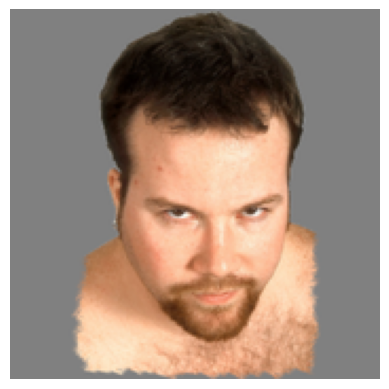

In [5]:
# sample plotting for an image
plt.imshow(input_images[0,0])
plt.grid(None)
plt.axis('off');

## Create dataloader

In [53]:
basic_transforms = A.Compose(
    [
        # A.RandomResizedCrop(224, 224),
        A.Resize(224, 224),
        A.HorizontalFlip(),
        A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
)

In [54]:
class ImageDataset(Dataset):
    def __init__ (self, images, transform=False):
        self.images = images
        self.transform = transform 

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx, 0]
        label = class_names[int(input_labels[idx] - 1)]

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label 

In [55]:
input_dataset = ImageDataset(input_images, basic_transforms)

In [56]:
input_loader = DataLoader(input_dataset, batch_size=BATCH_SIZE, shuffle=True)

Visualize augmentations

In [57]:
def visualize_augmentations(dataset, idx=0, samples=15, cols=5, random_img=False):

    dataset = copy.deepcopy(dataset)

    # remove the normalize and tensor conversion from augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols 

    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,8))

    for i in range(samples):
        if random_img:
            idx = np.random.randint(1, 92)
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f"Class: {lab}")
    plt.tight_layout(pad=1)

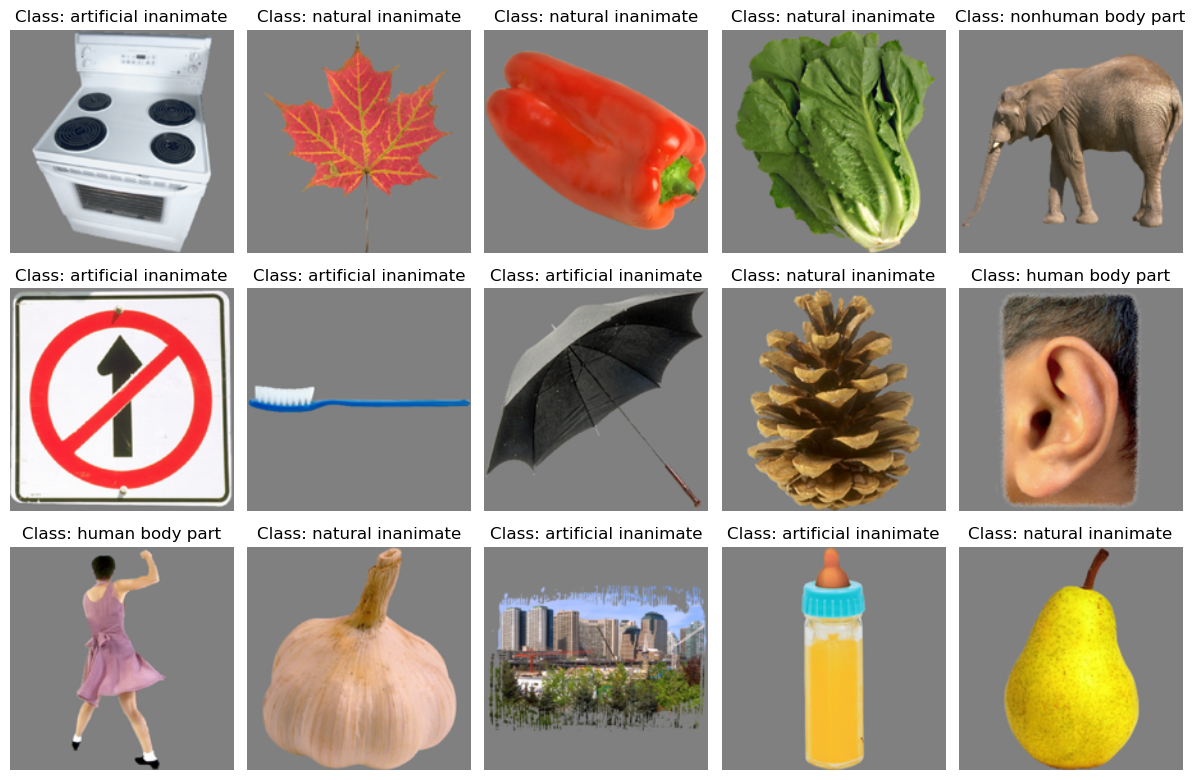

In [58]:
visualize_augmentations(input_dataset, random_img=True)

Check the number of images and the classes in our input dataset.

In [59]:
def getClassBreakdown(data):
    class_dict = {'artificial inanimate': 0,
                  'human body part': 0,
                  'human face': 0,
                  'natural inanimate': 0,
                  'nonhuman body part': 0,
                  'nonhuman face': 0}
    # iterate through all items
    for i in range(data.__len__()):
        # get class label
        label = data.__getitem__(i)[1]
        # update counter dict
        class_dict[label] = class_dict[label] + 1
    return class_dict

In [60]:
getClassBreakdown(input_dataset)

{'artificial inanimate': 24,
 'human body part': 12,
 'human face': 11,
 'natural inanimate': 22,
 'nonhuman body part': 12,
 'nonhuman face': 11}

# Implement neural network

## ResNet18

In [68]:
model18 = torch.hub.load('pytorch/vision:v0.10.0',
                       'resnet18',
                       weights='ResNet18_Weights.DEFAULT')

Using cache found in /Users/oliviayoo/.cache/torch/hub/pytorch_vision_v0.10.0


In [69]:
for num, layer in enumerate(model18._modules.keys()):
    print(num, layer)

0 conv1
1 bn1
2 relu
3 maxpool
4 layer1
5 layer2
6 layer3
7 layer4
8 avgpool
9 fc


In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)